# Week 3: The Final Ensemble Model
### Using SMOTE, Named Entity Recognition, TextRank to optimize the model

In [1]:
import re
import string
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
dir_data = '../data/nba_reg18/'

ds_sub = pd.DataFrame()
ds_com = pd.DataFrame()

nf_subs = 7 #7 files for submissions
nf_coms = 12 #12 files for comments

In [3]:
for icom in range(1, nf_subs+1):
    path_ds = dir_data + 'nba_submissions_reg18_' + str(icom) + '.csv'
    ds_cur = pd.read_csv(path_ds, index_col = 0, parse_dates = ['created'])
    ds_sub = ds_sub.append(ds_cur).drop_duplicates()

In [4]:
for icom in range(1, nf_coms+1):
    path_ds = dir_data + 'nba_comments_reg18_' + str(icom) + '.csv'
    ds_cur = pd.read_csv(path_ds, index_col = 0, parse_dates = ['created'])
    ds_com = ds_com.append(ds_cur).drop_duplicates()

In [5]:
print('No. of threads:')
print(ds_sub.shape[0])
print('No. of comments:')
print(ds_com.shape[0])

No. of threads:
92383
No. of comments:
2064767


In [6]:
# put submissions and comments together
ds = pd.concat([ds_sub[['author', 'flair', 'title', 'created']].rename(columns = {'flair':'team', 'title':'text'}),
                ds_com[['author', 'flair', 'text', 'created']].rename(columns = {'flair':'team'})],
               ignore_index = True)

In [7]:
# drop empty texts
ds.dropna(inplace = True)

In [8]:
print('No. of Total Data:')
print(ds.shape[0])

No. of Total Data:
1731127


### Standerdize Team Name

In [9]:
import sys
sys.path.insert(1, '../scripts') #add my scripts path
from teamname_stdize import teamname_stdize

In [10]:
# get rid of the weired pandas float nan
ds.loc[ds['team'].isnull().values, 'team'] = 'NONE'

In [11]:
ds = teamname_stdize(ds)

In [12]:
# load team names
team_names = pd.read_csv('../data/teams', names = ['name', 'abbrs'])
team_abbrs = team_names['abbrs'].to_list()

In [13]:
print('No. Total:')
print(ds.shape)
ds = ds.loc[ds['team'].isin(team_abbrs), :]
print('No. for 31 Teams:')
print(ds.shape)

No. Total:
(1731127, 4)
No. for 31 Teams:
(1617815, 4)


In [14]:
#ds.to_csv('ds_orig.csv')

# Text Preprocessing

In [15]:
from preprocess import preprocess_one

In [16]:
b_punc = True # we do want to remove punctuation
ds['text'] = ds['text'].apply(lambda x: preprocess_one(x, b_punc))

# Use spacy to do name entity recognition
### Implemented in the other script: ../scripts/ner.py

In [17]:
ner1 = pd.read_csv('entity1.csv', index_col = 0)
ner2 = pd.read_csv('entity2.csv', index_col = 0)
ner3 = pd.read_csv('entity3.csv', index_col = 0)

In [18]:
ner = pd.concat([ner1,ner2,ner3])

In [19]:
ds = ds.join(ner)

In [20]:
ds_sub = ds.loc[ds['entity'].notnull(),:]

In [21]:
print('Original size:')
print(ds.shape[0])
print('Rows with some entities:')
print(ds_sub.shape[0])

Original size:
1617815
Rows with some entities:
949634


In [22]:
# No. of Posts per user
post_count = ds_sub.groupby(['author'])['text'].count()

Text(0, 0.5, '# of Users')

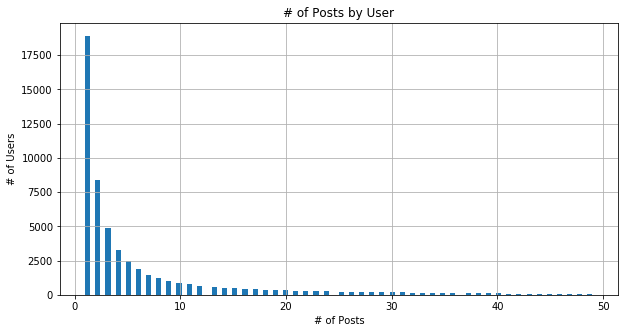

In [23]:
post_count.loc[post_count < 50].hist(bins=100, figsize=(10,5))
plt.title('# of Posts by User')
plt.xlabel('# of Posts')
plt.ylabel('# of Users')

In [24]:
# concat all texts by users
ds_user = ds_sub.groupby(['author', 'team'])['text'].apply(lambda x: ' '.join(x)).reset_index()

In [25]:
# concat all entities by users
ds_user_ents = ds_sub.groupby(['author', 'team'])['entity'].apply(lambda x: ' '.join(x)).reset_index()

In [26]:
ds_user = ds_user.join(ds_user_ents['entity'])

# Visit History Data
### What other forums (e.g. Lakers forum) did the user comment before?
### Scraped in scrap_user_history.ipynb

In [27]:
# load history data
ds_history = pd.DataFrame()
for i in range(1,6):
    ds_bot = pd.read_csv('bot'+str(i)+'_final.csv', index_col = 0)
    ds_history = ds_history.append(ds_bot)

In [28]:
# join history to total data
ds_all = ds_user.merge(ds_history, how = 'left', left_on = 'author', right_on = 'user')

In [29]:
ds_all.dropna(inplace = True)

In [30]:
print('Total data used:')
print(ds_all.shape[0])

Total data used:
56878


Text(0, 0.5, '# of Fans')

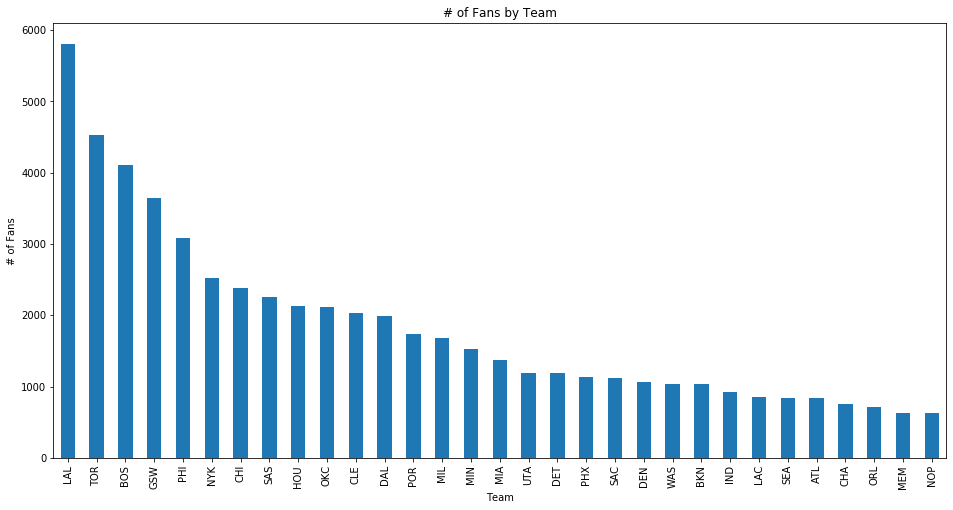

In [31]:
ds_all.groupby('team')['author'].count().sort_values(ascending=False).plot.bar(figsize=(16,8))
plt.title('# of Fans by Team')
plt.xlabel('Team')
plt.ylabel('# of Fans')

In [32]:
ds_all.drop(['user', 'count'], axis = 1, inplace = True)

# Training and Testing set (80/20)

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(ds_all[['text', 'entity', 'history']], 
                                                    ds_all['team'], test_size=0.20, random_state=0)

# MVP Model: TF-IDF and MultinomialNB, using text data as input

In [35]:
# feature extraction using tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [36]:
estimators = [('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 1), stop_words='english', max_df=.6)),
              ('clf', MultinomialNB())]
mvp = Pipeline(estimators)

In [37]:
mvp.fit(X_train['text'], y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.6, max_features=1000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [38]:
print('Accuracy on training set:')
print(mvp.score(X_train['text'], y_train))

Accuracy on training set:
0.3080963474133005


In [39]:
print('Accuracy on testing set:')
print(mvp.score(X_test['text'], y_test))

Accuracy on testing set:
0.28894163150492264


In [40]:
from sklearn.metrics import balanced_accuracy_score
print('MVP model balanced accuracy:')
print(balanced_accuracy_score(y_test, mvp.predict(X_test['text'])))

MVP model balanced accuracy:
0.19660679214557694


In [41]:
from cal_auc import cal_auc
print('MVP model micro AUC:')
print(cal_auc(mvp, X_test['text'], y_test, 'micro'))

MVP model micro AUC:
0.7991945866038864


In [42]:
print('MVP model macro AUC:')
print(cal_auc(mvp, X_test['text'], y_test, 'macro'))

MVP model macro AUC:
0.7556733658490712


In [43]:
print('MVP model weighted AUC:')
print(cal_auc(mvp, X_test['text'], y_test, 'weighted'))

MVP model weighted AUC:
0.7565973319736987


In [44]:
from sklearn.metrics import matthews_corrcoef
print('MVP model MCC:')
print(matthews_corrcoef(y_test, mvp.predict(X_test['text'])))

MVP model MCC:
0.2544940071087173


In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, mvp.predict(X_test['text'])))

              precision    recall  f1-score   support

         ATL       0.59      0.14      0.23       155
         BKN       0.46      0.08      0.14       213
         BOS       0.37      0.36      0.37       811
         CHA       0.69      0.17      0.28       143
         CHI       0.43      0.16      0.23       477
         CLE       0.52      0.04      0.08       400
         DAL       0.57      0.33      0.41       414
         DEN       0.71      0.20      0.31       209
         DET       0.65      0.18      0.29       240
         GSW       0.32      0.35      0.34       753
         HOU       0.56      0.22      0.32       459
         IND       0.81      0.09      0.16       190
         LAC       0.71      0.03      0.06       166
         LAL       0.15      0.78      0.26      1157
         MEM       0.82      0.07      0.13       131
         MIA       0.50      0.05      0.09       251
         MIL       0.54      0.17      0.26       341
         MIN       0.64    

/home/bearsun/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
pred_mvp_logp = mvp.predict_log_proba(X_test['text'])

In [47]:
pred_train_mvp_logp = mvp.predict_log_proba(X_train['text'])

# Model 2: TF-IDF, SMOTE and MultinomialNB, using recognized entities as input

In [48]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [49]:
model2 = Pipeline([('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 1), stop_words='english', max_df=.6)),
                   ('sampling', SMOTE(random_state = 0)),
                   ('clf', MultinomialNB())
                   ])

In [50]:
model2.fit(X_train['entity'], y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.6, max_features=1000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                     

In [51]:
print('Accuracy on training set:')
print(model2.score(X_train['entity'], y_train))

Accuracy on training set:
0.3737418135466573


In [52]:
print('Accuracy on testing set:')
print(model2.score(X_test['entity'], y_test))

Accuracy on testing set:
0.34906821378340364


In [53]:
print('Model 2 balanced accuracy:')
print(balanced_accuracy_score(y_test, model2.predict(X_test['entity'])))

Model 2 balanced accuracy:
0.3578964831868031


In [54]:
print('Model2 micro AUC:')
print(cal_auc(model2, X_test['entity'], y_test, 'micro'))

Model2 micro AUC:
0.7907391363213232


In [55]:
print('Model2 macro AUC:')
print(cal_auc(model2, X_test['entity'], y_test, 'macro'))

Model2 macro AUC:
0.7723999238800217


In [56]:
print('Model2 weighted AUC:')
print(cal_auc(model2, X_test['entity'], y_test, 'weighted'))

Model2 weighted AUC:
0.7676767243585525


In [57]:
print('Model2 MCC:')
print(matthews_corrcoef(y_test.values, model2.predict(X_test['entity'])))

Model2 MCC:
0.32477539318536575


In [58]:
print(classification_report(y_test, model2.predict(X_test['entity'])))

              precision    recall  f1-score   support

         ATL       0.07      0.45      0.13       155
         BKN       0.34      0.39      0.36       213
         BOS       0.49      0.32      0.38       811
         CHA       0.29      0.38      0.33       143
         CHI       0.34      0.24      0.28       477
         CLE       0.24      0.29      0.26       400
         DAL       0.46      0.44      0.45       414
         DEN       0.30      0.44      0.36       209
         DET       0.33      0.34      0.34       240
         GSW       0.40      0.36      0.38       753
         HOU       0.35      0.37      0.36       459
         IND       0.31      0.37      0.34       190
         LAC       0.22      0.33      0.26       166
         LAL       0.50      0.30      0.37      1157
         MEM       0.26      0.36      0.30       131
         MIA       0.20      0.21      0.20       251
         MIL       0.37      0.42      0.39       341
         MIN       0.39    

In [59]:
pred_model2_logp = model2.predict_log_proba(X_test['entity'])

In [60]:
pred_train_model2_logp = model2.predict_log_proba(X_train['entity'])

#  Model 3: TextRank + CountVectorizer + SMOTE and MultinomialNB, using recognized entities as input
### TextRank was done by gensim in ../scripts/textrank.py

In [61]:
# read textrank vocabulary
f = open('kwords2.txt','r')
kwords = f.read()
f.close()
vocabulary = kwords.split('@')

In [62]:
from sklearn.feature_extraction.text import CountVectorizer

In [63]:
model3 = Pipeline([('bow', CountVectorizer(vocabulary=vocabulary[:1000])),
                   ('sampling', SMOTE(random_state = 0)),
                   ('clf', MultinomialNB())])

In [64]:
model3.fit(X_train['entity'], y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None,
                                 vocabulary=['nb...
                                             'giannis', 'gianni', 'giannies',
                                             'kawhi', 'kawhis', 'kyrie',
                                             'kyries', 'kyri', 'minutes', ...])),
                ('sampling',
                 SMOTE(k_neighbors=5, kin

In [65]:
print('Accuracy on training set:')
print(model3.score(X_train['entity'], y_train))

Accuracy on training set:
0.32271108962243417


In [66]:
print('Accuracy on testing set:')
print(model3.score(X_test['entity'], y_test))

Accuracy on testing set:
0.31795007032348804


In [67]:
from sklearn.metrics import balanced_accuracy_score
print('Model 3 balanced accuracy:')
print(balanced_accuracy_score(y_test, model3.predict(X_test['entity'])))

Model 3 balanced accuracy:
0.3280856588611431


In [68]:
print('Model3 micro AUC:')
print(cal_auc(model3, X_test['entity'], y_test, 'micro'))

Model3 micro AUC:
0.7697328497171729


In [69]:
print('Model3 macro AUC:')
print(cal_auc(model3, X_test['entity'], y_test, 'macro'))

Model3 macro AUC:
0.7584220585944997


In [70]:
print('Model3 weighted AUC:')
print(cal_auc(model3, X_test['entity'], y_test, 'weighted'))

Model3 weighted AUC:
0.7569383430295958


In [71]:
print('Model3 MCC:')
print(matthews_corrcoef(y_test.values, model3.predict(X_test['entity'])))

Model3 MCC:
0.2943931013494082


In [72]:
print(classification_report(y_test, model3.predict(X_test['entity'])))

              precision    recall  f1-score   support

         ATL       0.06      0.50      0.10       155
         BKN       0.27      0.35      0.30       213
         BOS       0.46      0.29      0.36       811
         CHA       0.33      0.39      0.36       143
         CHI       0.31      0.22      0.26       477
         CLE       0.22      0.26      0.23       400
         DAL       0.43      0.43      0.43       414
         DEN       0.40      0.44      0.42       209
         DET       0.30      0.32      0.31       240
         GSW       0.40      0.33      0.36       753
         HOU       0.39      0.34      0.37       459
         IND       0.27      0.32      0.29       190
         LAC       0.21      0.34      0.26       166
         LAL       0.48      0.25      0.33      1157
         MEM       0.21      0.34      0.26       131
         MIA       0.22      0.17      0.19       251
         MIL       0.36      0.37      0.36       341
         MIN       0.39    

In [73]:
pred_model3_logp = model3.predict_log_proba(X_test['entity'])

In [74]:
pred_train_model3_logp = model3.predict_log_proba(X_train['entity'])

# Model 4: TF-IDF, SMOTE and MultinomialNB, using Visit History Data

In [75]:
model4 = Pipeline([('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 1), stop_words='english', max_df=.6)),
                   ('sampling', SMOTE(random_state=0)),
                   ('clf', MultinomialNB())])

In [76]:
model4.fit(X_train['history'], y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.6, max_features=1000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                     

In [77]:
print('Accuracy on training set:')
print(model4.score(X_train['history'], y_train))

Accuracy on training set:
0.6052261439057623


In [78]:
print('Accuracy on testing set:')
print(model4.score(X_test['history'], y_test))

Accuracy on testing set:
0.555028129395218


In [79]:
from sklearn.metrics import balanced_accuracy_score
print('Model 4 balanced accuracy:')
print(balanced_accuracy_score(y_test, model4.predict(X_test['history'])))

Model 4 balanced accuracy:
0.5461553912246749


In [80]:
print('Model4 micro AUC:')
print(cal_auc(model4, X_test['history'], y_test, 'micro'))

Model4 micro AUC:
0.8989468623397939


In [81]:
print('Model4 macro AUC:')
print(cal_auc(model4, X_test['history'], y_test, 'macro'))

Model4 macro AUC:
0.8848898704920578


In [82]:
print('Model4 weighted AUC:')
print(cal_auc(model4, X_test['history'], y_test, 'weighted'))

Model4 weighted AUC:
0.8906722535174615


In [83]:
print('Model4 MCC:')
print(matthews_corrcoef(y_test.values, model4.predict(X_test['history'])))

Model4 MCC:
0.536666824547824


In [84]:
print(classification_report(y_test, model4.predict(X_test['history'])))

              precision    recall  f1-score   support

         ATL       0.36      0.60      0.45       155
         BKN       0.33      0.48      0.39       213
         BOS       0.87      0.57      0.69       811
         CHA       0.31      0.54      0.40       143
         CHI       0.66      0.51      0.58       477
         CLE       0.61      0.48      0.54       400
         DAL       0.62      0.49      0.55       414
         DEN       0.57      0.56      0.57       209
         DET       0.43      0.53      0.48       240
         GSW       0.54      0.56      0.55       753
         HOU       0.76      0.55      0.63       459
         IND       0.49      0.53      0.51       190
         LAC       0.33      0.51      0.40       166
         LAL       0.68      0.51      0.58      1157
         MEM       0.35      0.47      0.40       131
         MIA       0.40      0.45      0.42       251
         MIL       0.72      0.61      0.66       341
         MIN       0.73    

In [85]:
pred_model4_logp = model4.predict_log_proba(X_test['history'])

In [86]:
pred_train_model4_logp = model4.predict_log_proba(X_train['history'])

# Ensemble Model: Add 4 predict_log_proba together to make prediction

In [87]:
# put all log_prob for each sample together to compare them
pred_logp = np.concatenate((pred_mvp_logp.reshape(1,-1), pred_model2_logp.reshape(1,-1),
                           pred_model3_logp.reshape(1,-1), pred_model4_logp.reshape(1,-1)))
ds_logp = pd.DataFrame(pred_logp.transpose(), columns = ['MVP', 'NER', 'NER+TEXTRANK', 'History'])

In [88]:
import seaborn as sns

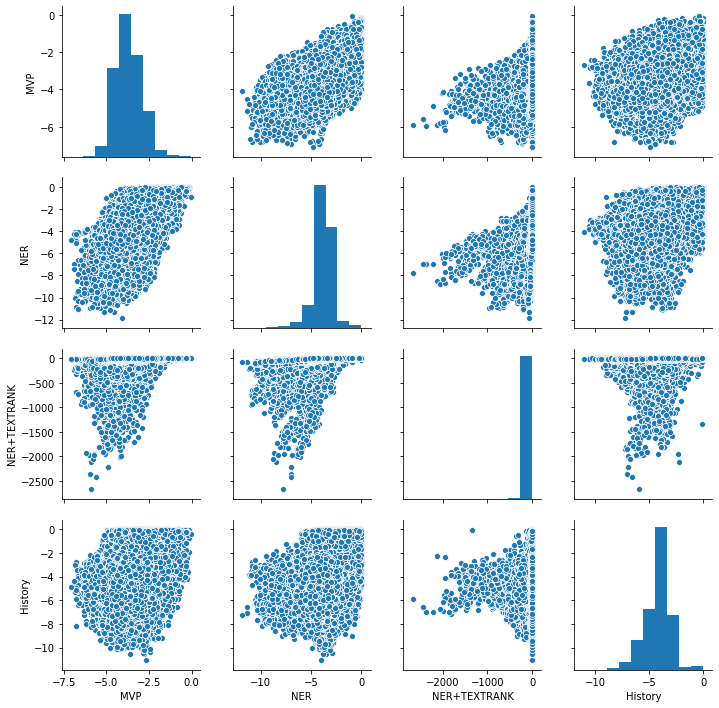

In [89]:
# correlation between predictions
sns.pairplot(ds_logp)

In [90]:
# combine training data logp as 4 features
pred_train_logp = np.concatenate((pred_train_mvp_logp, pred_train_model2_logp,
                           pred_train_model3_logp, pred_train_model4_logp), axis = 1)

In [91]:
# combine testing data logp as 4 features for testing set
pred_test_logp = np.concatenate((pred_mvp_logp, pred_model2_logp,
                                 pred_model3_logp, pred_model4_logp), axis=1)

### Fit a Logistic Regression model on the training set, which takes the predict_log_probability from 4 models as inputs/features (31 classes * 4 models = 124 features)

In [92]:
from sklearn.linear_model import LogisticRegression
ensemble = LogisticRegression(solver = 'lbfgs', multi_class = 'ovr', n_jobs = 3)
ensemble.fit(pred_train_logp, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=3, penalty='l2', random_state=None,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [93]:
print('Accuracy on training set:')
ensemble.score(pred_train_logp, y_train)

Accuracy on training set:


0.7000131862335721

In [94]:
print('Accuracy on testing set:')
ensemble.score(pred_test_logp, y_test)

Accuracy on testing set:


0.6378340365682138

In [95]:
from sklearn.metrics import balanced_accuracy_score
print('Ensemble model balanced accuracy:')
print(balanced_accuracy_score(y_test, ensemble.predict(pred_test_logp)))

Ensemble model balanced accuracy:
0.6003604985110881


In [96]:
print('Ensemble model micro AUC:')
print(cal_auc(ensemble, pred_test_logp, y_test, 'micro'))

Ensemble model micro AUC:
0.9344319889571022


In [97]:
print('Ensemble model macro AUC:')
print(cal_auc(ensemble, pred_test_logp, y_test, 'macro'))

Ensemble model macro AUC:
0.9174334126950697


In [98]:
print('Ensemble model weighted AUC:')
print(cal_auc(ensemble, pred_test_logp, y_test, 'weighted'))

Ensemble model weighted AUC:
0.9228822193774017


In [99]:
print('Ensemble model MCC:')
print(matthews_corrcoef(y_test.values, ensemble.predict(pred_test_logp)))

Ensemble model MCC:
0.6187572982283672


In [100]:
print(classification_report(y_test, ensemble.predict(pred_test_logp)))

              precision    recall  f1-score   support

         ATL       0.67      0.63      0.65       155
         BKN       0.70      0.50      0.58       213
         BOS       0.64      0.70      0.67       811
         CHA       0.65      0.64      0.65       143
         CHI       0.66      0.58      0.61       477
         CLE       0.62      0.54      0.57       400
         DAL       0.70      0.63      0.66       414
         DEN       0.72      0.68      0.70       209
         DET       0.70      0.58      0.63       240
         GSW       0.55      0.68      0.61       753
         HOU       0.73      0.63      0.68       459
         IND       0.76      0.57      0.65       190
         LAC       0.66      0.45      0.54       166
         LAL       0.51      0.71      0.59      1157
         MEM       0.62      0.44      0.52       131
         MIA       0.64      0.49      0.56       251
         MIL       0.69      0.68      0.68       341
         MIN       0.74    